#### Описание проекта
- Входные данные: из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

- Задача: выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

- Цель: планирование кампании на 2017-й год.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#откроем датасет
try:
 df = pd.read_csv('/datasets/games.csv')
except:
 df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
#выведем 5 первых строк датасета
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
#ознакомимся с основной информацией
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
#проверим количество пропусков
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
df.duplicated().sum()

0

#### Шаг 2. Подготовим данные:
1. все названия столбцов приведем к нижнему регистру;
2. пропуски в столбцах 'name', 'genre' удалим, т.к. их малое количество;
3. пропуски с данными о годе выпуска заполним синтетическим значением в -10, чтобы сохранить данные, и приведем к целому числу;
4. изучим пропуски в столбцах с рейтингом, оценкой критиков и оценкой пользователей.

In [7]:
#приведем все названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [8]:
df.dropna(subset=['name','genre'], inplace=True)
df['year_of_release'] = df['year_of_release'].fillna(-10)
df['year_of_release'] = df['year_of_release'].astype('int') #меняем тип

In [9]:
df['year_of_release'].describe() #check

count    16713.000000
mean      1974.030396
std        253.833082
min        -10.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

In [10]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [11]:
print('Оценка критиков, пропусков:', df['critic_score'].isna().sum())
print('Оценка пользователей, пропусков:', df['user_score'].isna().sum())
print('Рейтинг, пропусков:', df['rating'].isna().sum()) #проверяем количество пропусков

Оценка критиков, пропусков: 8576
Оценка пользователей, пропусков: 6699
Рейтинг, пропусков: 6764


Пропусков очень много, мы не можем их удалить.
Изучим пропуски в столбцах

In [12]:
df['user_score'].unique() #изучим уникальные значения столбца оценка пользователей

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Неопознанный tbd (to be determined?) не позволяет перевести тип столбца во float. Построим сводную таблицу, чтобы понять насколько масштабно tbd присутствует в данных.

In [13]:
user_tbd = df.query('user_score == "tbd" and year_of_release != -10')
user_tbd.pivot_table(index = 'year_of_release', values = 'user_score', aggfunc = 'count')

,user_score
year_of_release,
1997,1
1999,8
2000,43
2001,82
2002,192
2003,95
2004,107
2005,121
2006,124


Данный термин есть во всех годах, и скорее всего связан с какой-то технической особенностью. Заменим это значение на nan и заполним пропуски заглушкой -1. Такой же заглушкой заполним и пропуски в столбце critic_score. Выбрано отрицательное значение, т.к. по условиям оценки от 0 до 10/100, а отрицательное число не даст забыть/пропустить.

In [14]:
df.loc[df['user_score'] == 'tbd','user_score'] = np.nan

In [15]:
df[(['critic_score','user_score'])] = df[(['critic_score','user_score'])].fillna(-1)
#заполняем пропуски -1

In [16]:
df['critic_score'] = df['critic_score'].astype('int') #приведем к целому числу
df['user_score'] = df['user_score'].astype('float64') #приведем к float64

Разберем пропуски в рейтинге.
Согласно вики, у ESRB рейтинги делятся на:
 - Е - для всех;
 - М - для взрослых;
 - Т - подростки;
 - Е10+ - от 10 лет и старше;
 - К-А - kids to adults (ныне Е);
 - АО - 18+;
 - ЕС - младшего возраста;
 - RP - рейтинг ожидается.

In [17]:
df['rating'].isna().sum()

6764

In [18]:
df['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

С чем связаны пропуски в рейтинге сказать сложно: возможно, что игра только, что вышла и рейтинга еще нет или что разработчик и не собирается получать рейтинг. Возможно, что это какая-то техническая ошибка.
Пропущенных данных очень много, поэтому заменим: 
- пропуски на 'unknown'
- АО -  на М;
- RP - на unknown;
- ЕС - на Е;
- К-А - на Е.

In [19]:
df['rating'] = df['rating'].fillna('unknown')
df.loc[df['rating'] == 'AO', 'rating'] = 'M'
df.loc[df['rating'] == 'RP', 'rating'] = 'unknown'
df.loc[df['rating'].isin(['EC', 'K-A']), 'rating'] = 'E'

In [20]:
df['rating'].value_counts()

unknown    6767
E          4001
T          2961
M          1564
E10+       1420
Name: rating, dtype: int64

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично
</div>

In [21]:
#check
print('Оценка критиков, пропусков:', df['critic_score'].isna().sum())
print('Оценка пользователей, пропусков:', df['user_score'].isna().sum())
print('Рейтинг, пропусков:', df['rating'].isna().sum()) #проверяем количество пропусков

Оценка критиков, пропусков: 0
Оценка пользователей, пропусков: 0
Рейтинг, пропусков: 0


In [22]:
# Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец
df['total_sales'] = df['na_sales'] + df['eu_sales']+ df['jp_sales']+ df['other_sales']

In [23]:
df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,unknown,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1,-1.0,unknown,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1,-1.0,unknown,28.31


#### Вывод:
Данные подготовлены для дальнейшей работы:
- все названия столбцов приведены к нижнему регистру;

произведена работа с пропусками: 
- незначительные пропуски в столбцах 'name','genre' удалены,
- в столбцах 'year_of_release' пропуски заменены на значение (-10) в целях сохранения сохранения данных;
- в столбцах 'user_score','critic_score' пропуски заменены на отрицательное значение (-1);
- в столбце 'rating' рейтинг ESRB приведен к актуальному состоянию, пропуски заменены на значение 'unknown';
- рассчитаны суммарные продажи по игре и записаны в отдельный столбец 'total_sales'.

### Шаг 3. Исследовательский анализ данных
Сколько игр выпускалось в разные годы? Важные ли данные за все периоды?

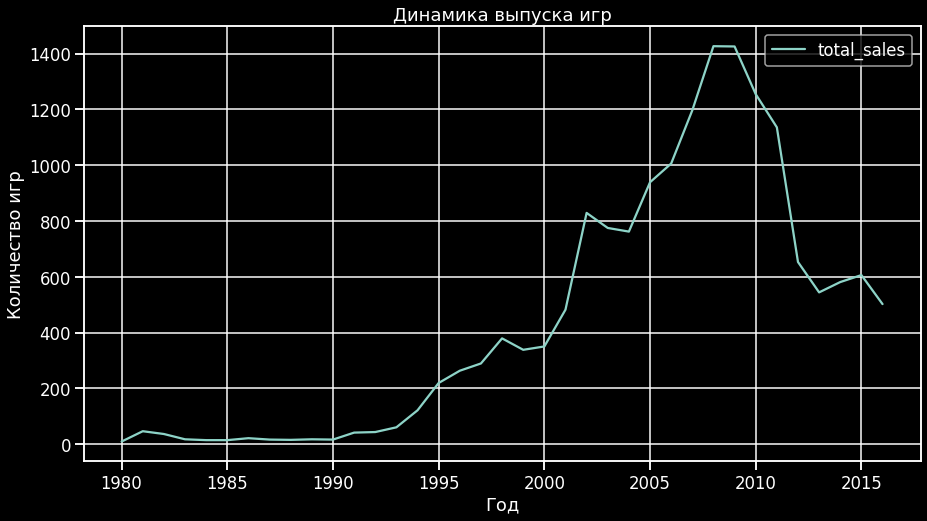

In [24]:
#проанализируем количество выпускаемых игр по годам
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
pivot_table_year = (df.query('year_of_release != -10')
 .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'count'))
pivot_table_year.plot(grid = True, figsize=(15,8))
plt.title('Динамика выпуска игр')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

Очевидно, что быстрый рост начался с 2000 годов, и продолжился до 2009 года после чего начался спад. Данные до 1995 года не являются актуальными по причинам давности и относительно малого количества выпускаемых игр, да и самих игроков.

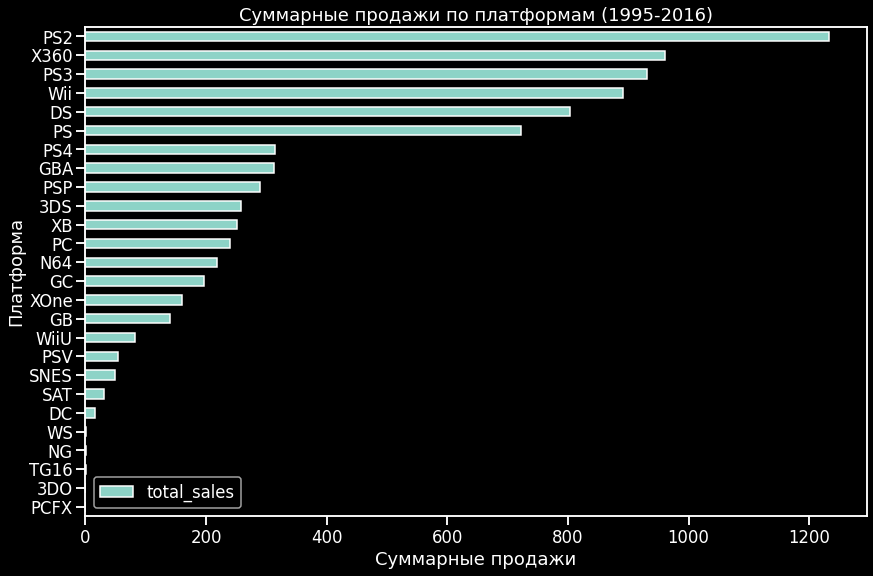

In [25]:
#посмотрим на суммарные продажи по плафтормам
(df.query('year_of_release >= 1995')
.pivot_table(index = 'platform', values = 'total_sales', aggfunc= 'sum')
.sort_values(by='total_sales', ascending=True)
.plot(y='total_sales', kind='barh', figsize=(14, 9)))
plt.title('Суммарные продажи по платформам (1995-2016)')
plt.xlabel('Суммарные продажи')
plt.ylabel('Платформа')
plt.show()

В очевидный ТОП-6 выделим следующие платформы:
 1. PS2;
 2. X360;
 3. PS3;
 4. Wii;
 5. DS;
 6. PS.

Text(0, 0.5, 'Суммарные продажи')

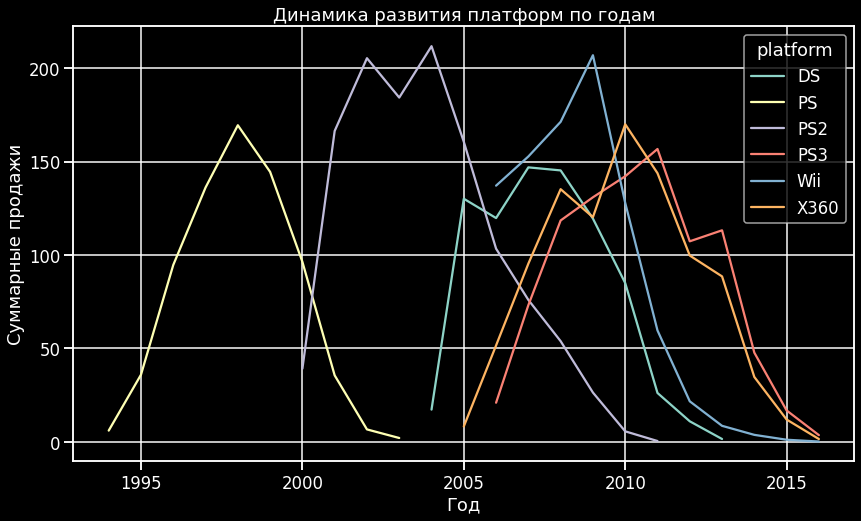

In [26]:
top_plat = df.query('platform in ["PS2", "X360", "PS3", "Wii", "DS", "PS"] and year_of_release >= 1990')
(
top_plat
.pivot_table(index = 'year_of_release', columns='platform', values = 'total_sales', aggfunc= 'sum')
.plot(figsize=(14, 8), grid=True)
)
plt.title('Динамика развития платформ по годам')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи')

За какой характерный срок появляются новые и изчезают старые платформы?

В среднем, мы видим, что "период актуальности" каждой платформы от 4 до 6 лет.

### Возьмите данные за актуальный период. Какие платформы лидируют по продажам, растут или падают?
Исходя из среднего "периода актуальности" 5 лет, возьмем данные за предшедствующие 3 года. Таким образом мы сможем увидеть те платформы, которые находятся или на пике или в периоде развития, платформы с "угасающей" тенденцией не будут влиять на данные.
Для прогнозирования продаж на 2017 год - возьмем данные за 2014-2016 года.

In [27]:
#создадим датафрейм с данными за 2014-2016 года
df_actually = df.query('year_of_release >= 2014')

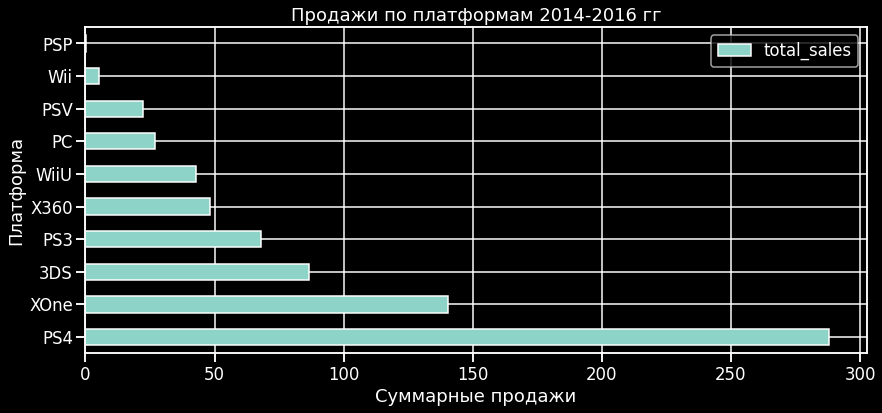

In [28]:
#посмотрим на суммарные продажи по платформам
(df_actually.pivot_table(index = 'platform', values = 'total_sales', aggfunc= 'sum')
.sort_values(by='total_sales', ascending=False)
.plot(y='total_sales', kind='barh', figsize=(14, 6), grid=True))
plt.title('Продажи по платформам 2014-2016 гг')
plt.xlabel('Суммарные продажи')
plt.ylabel('Платформа')
plt.show()

In [29]:
df_actually['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

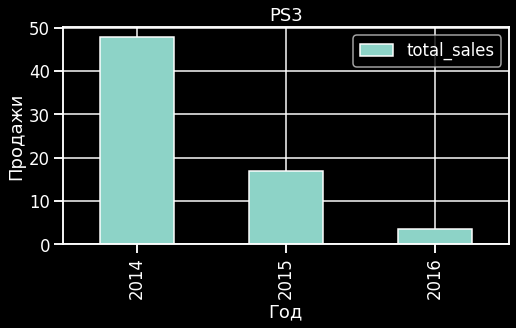

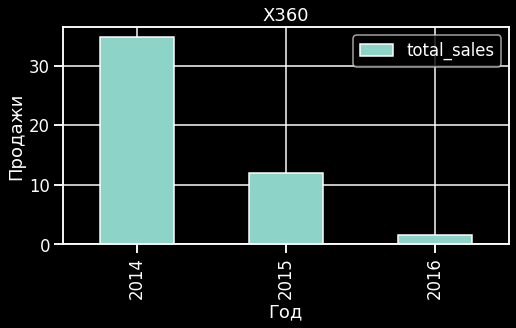

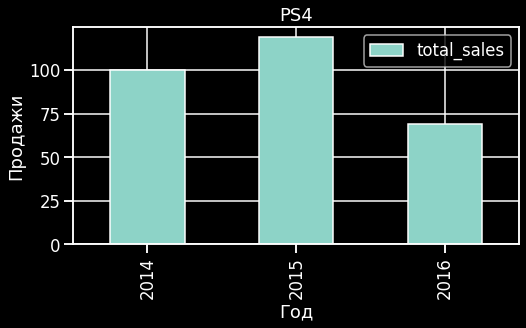

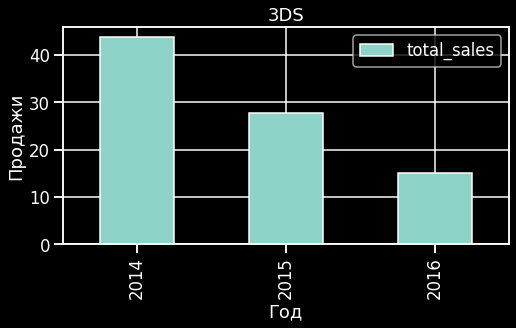

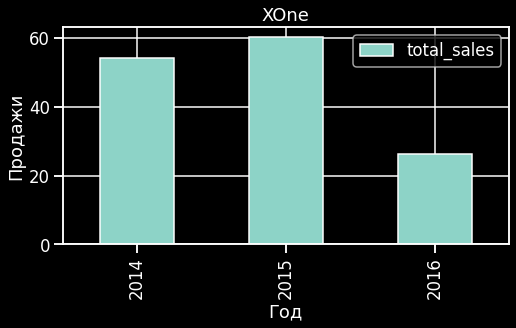

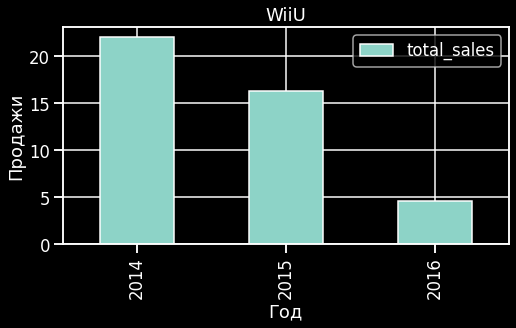

In [30]:
top_plat = ['PS3', 'X360', 'PS4', '3DS', 'XOne','WiiU']
for platform in top_plat:
    (df_actually.loc[df_actually['platform'] == platform]
        .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc= 'sum')
        .sort_values(by='year_of_release')
        .plot(y='total_sales', kind='bar', figsize=(8, 4), grid=True))
    plt.xlabel('Год')
    plt.ylabel('Продажи')
    plt.title(platform)
    plt.show()

In [31]:
#создадим датафрейм со срезом актуальных платформ
df_plat = df_actually.query('platform == "PS3"| \
platform == "X360" |\
platform == "PS4" |\
platform == "3DS" |\
platform == "XOne" |\
platform == "WiiU" ')

[Text(0.5, 0, 'Год'), Text(0, 0.5, 'Продажи')]

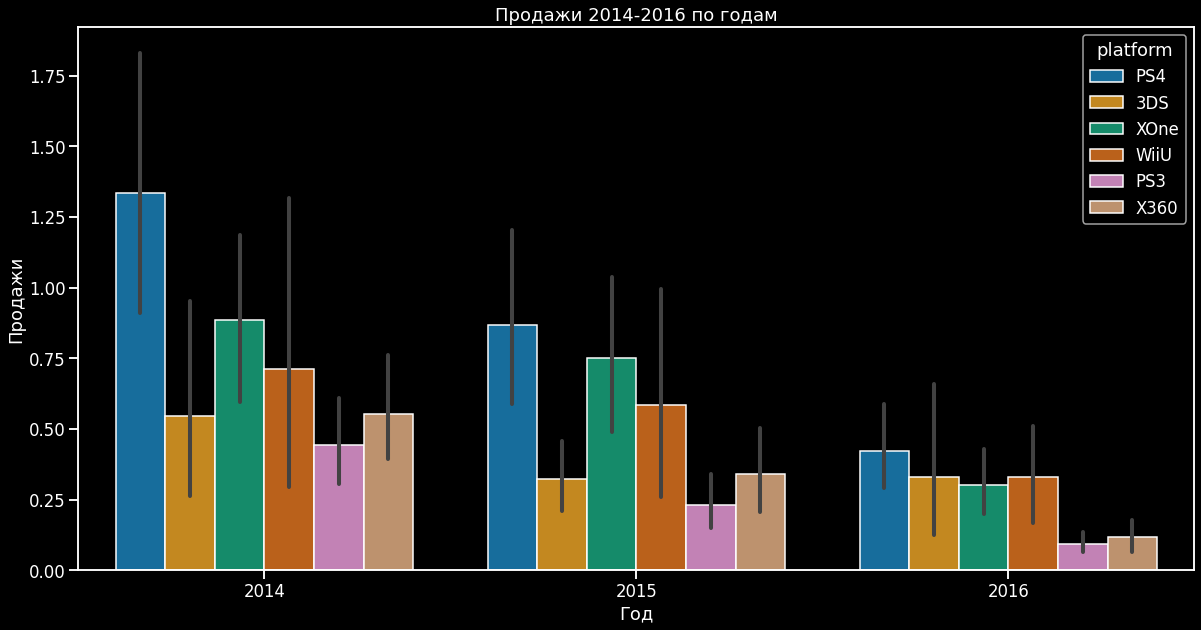

In [32]:
#построим график продаж по годам
fig = plt.figure(figsize = (20,10))
sns.set_palette("colorblind")
ax = sns.barplot(x='year_of_release',
            y='total_sales',
            hue="platform",
            data=df_plat,
            palette="colorblind",
)

ax.set_title('Продажи 2014-2016 по годам')
ax.set(xlabel='Год', ylabel='Продажи')


Несомненный лидер по продажам - платформа PS4. Однако, все платформы показывают спад, но т.к. за 2016 год данные неполные, то PS4 и XOne могут считаться потенциально прибыльными платформами. Данные за 2016 год неполные, но тем не менее, можно выделить такие платформы:
- PS4;
- XOne;
- X360;
- WiiU.

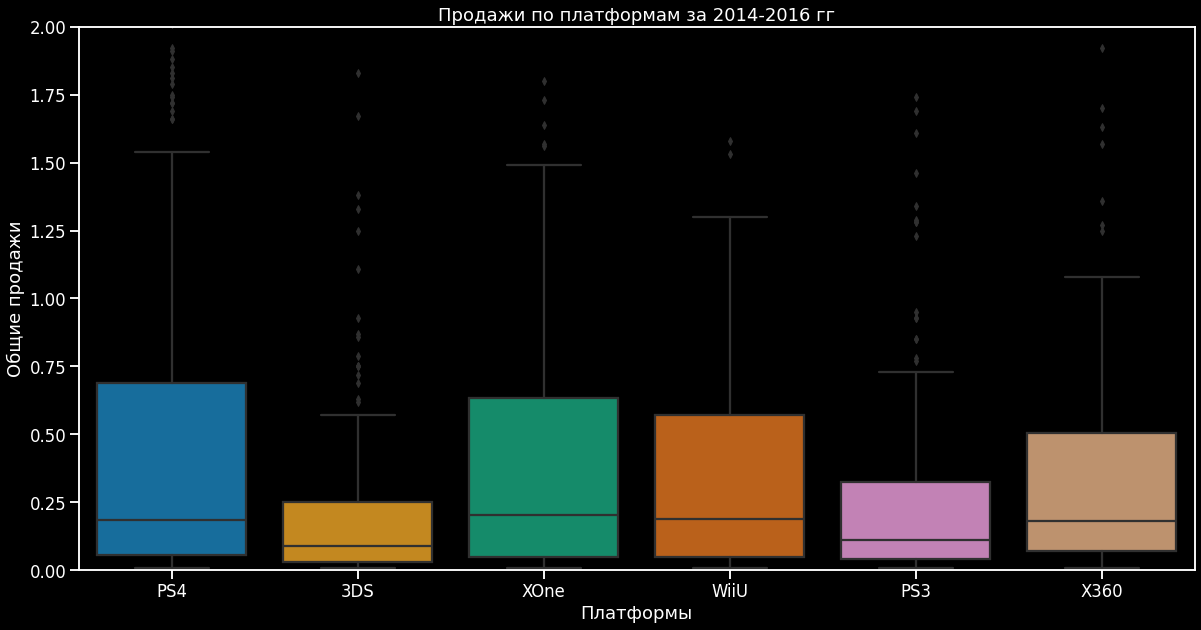

In [33]:
#строим боксплот по продажам всех платформ за 2014-2016гг
fig = plt.figure(figsize = (20,10))
sns.boxplot(data = df_plat, y = 'total_sales', x='platform').set(title = 'Продажи по платформам за 2014-2016 гг', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 2))
plt.show()

In [34]:
df_plat.pivot_table(index = 'platform', values = 'total_sales', aggfunc= ['median', 'mean','count','sum'])

,median,mean,count,sum
,total_sales,total_sales,total_sales,total_sales
platform,,,,
3DS,0.090,0.408868,212,86.68
PS3,0.110,0.311324,219,68.18
PS4,0.185,0.766356,376,288.15
WiiU,0.190,0.588767,73,42.98
X360,0.180,0.434414,111,48.22
XOne,0.205,0.615614,228,140.36


По боксплоту и сводной таблицe мы видим, что у каждой платформы выбросы есть.
Однозначно лидируют PS4, XOne, WiiU и X360. 
Выберем на этих платформах те игры, которые дают для платформ общие продажи выше 3-го квартиля.

In [35]:
df_plat.groupby(['platform'])['total_sales'].quantile(0.75)

platform
3DS     0.2500
PS3     0.3250
PS4     0.6900
WiiU    0.5700
X360    0.5050
XOne    0.6325
Name: total_sales, dtype: float64

In [36]:
top_games_ps4 = df_plat.query('platform == "PS4" and total_sales >= 0.69')
#top_games_3ds = df_plat.query('platform == "3DS" and total_sales >= 0.25')
top_games_xone = df_plat.query('platform == "XOne" and total_sales >= 0.63')
top_games_wiiu = df_plat.query('platform == "WiiU" and total_sales >= 0.57')
#top_games_ps3 = df_plat.query('platform == "PS3" and total_sales >= 0.32')
top_games_x360 = df_plat.query('platform == "X360" and total_sales >= 0.5')

In [37]:
top_games = pd.concat([top_games_ps4, top_games_xone, top_games_wiiu,top_games_x360 ], axis=0)

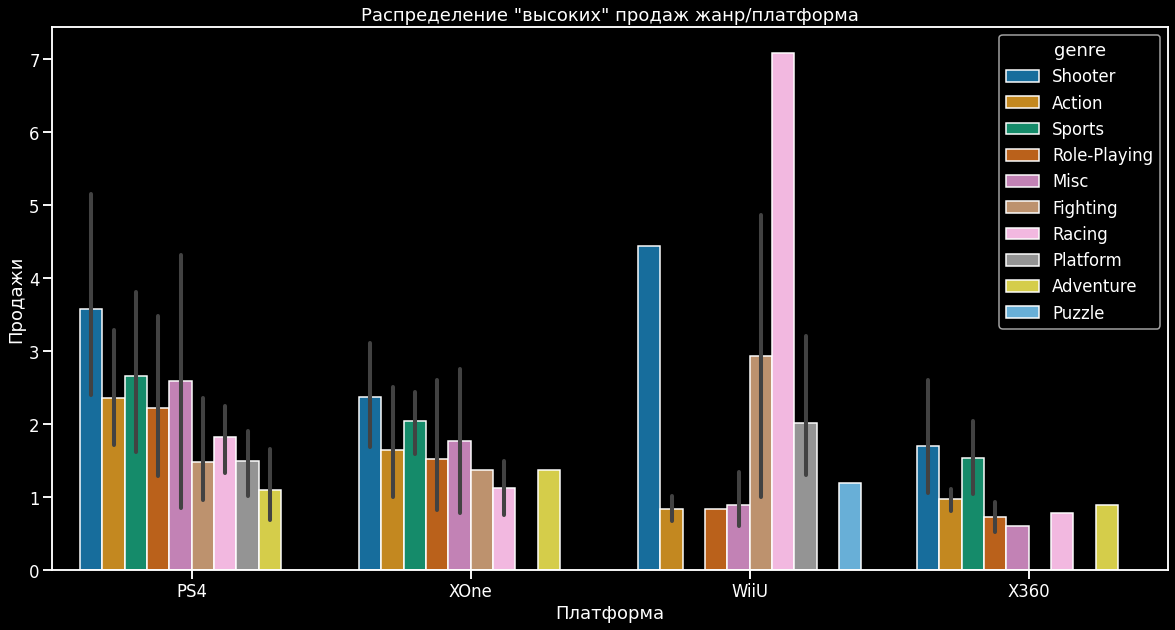

In [38]:
fig = plt.figure(figsize = (20,10))
sns.set_palette("colorblind")
ax = sns.barplot(x='platform',
            y='total_sales',
            hue="genre",
            data=top_games,
            palette="colorblind",
)
plt.title('Распределение "высоких" продаж жанр/платформа')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

На график вынесены 4 платформы с наиболее высокими медианными продажами и распределение продаж по жанру.
Можно сделать вывод:
- у PS4 наиболее продаются shooter, sports, misc. И в целом платформа имеет хорошие показатели и по остальным жанрам;
- XOne так же лидируют shooter, sports, misc;
- WiiU - racing, shooter, fighting;
- X360 - shooter, sports, action.

Платформы PS4 и XOne выглядят более стабильными, продажи выше медианы встречаются достаточно часто и представлены во многих жанрах.

### Влияние на продажи внутри одной популярной платформы отзывы пользователей и критиков.
Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Определять зависимость будем при помощи корреляции, определим значения для силы коэффициента корреляции.
- от 0 до 0,3 - очень слабая
- от 0,3 до 0,5 - слабая
- от 0, 5 до 0,7 - средняя
- от 0,7 до 0, 9 - сильная
- от 0,9 до 1 - очень сильная

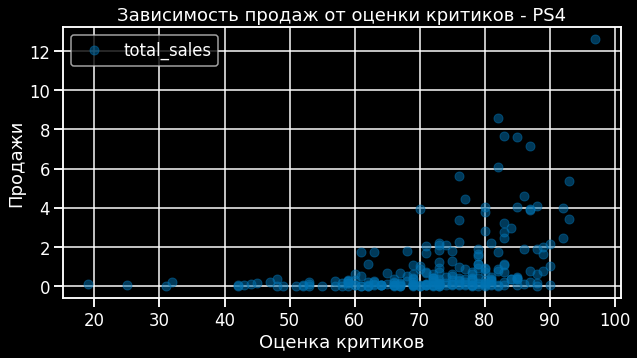

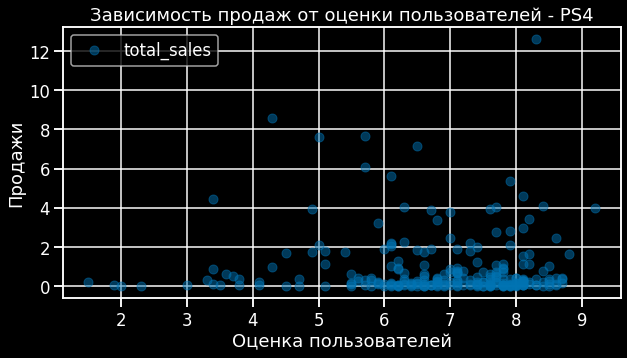

Коэффициент корреляции продажи/оценка пользователей: -0.04
Коэффициент корреляции продажи/оценка критиков: 0.34


In [39]:
# Построим диаграммы рассеяния для платформы PS4, исключим значения -1
ps4_plat = df_plat.query('platform == "PS4" and critic_score != -1')
ps4_plat.plot(
 x='critic_score',
 y='total_sales',
 style='o',
 grid=True,
 figsize=(10, 5),
 alpha=0.5,
)
plt.title('Зависимость продаж от оценки критиков - PS4')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи')
plt.show()

ps4_plat = df_plat.query('platform == "PS4" and user_score != -1')
ps4_plat.plot(
 x='user_score',
 y='total_sales',
 style='o',
 grid=True,
 figsize=(10, 5),
 alpha=0.5,
)
plt.title('Зависимость продаж от оценки пользователей - PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи')
plt.show()

# Расчет коэффициента корреляции
print('Коэффициент корреляции продажи/оценка пользователей:', \
      "{0:.2}".format(ps4_plat['total_sales'].corr(ps4_plat['user_score'])))
print('Коэффициент корреляции продажи/оценка критиков:', \
      "{0:.2}".format(ps4_plat['total_sales'].corr(ps4_plat['critic_score'])))

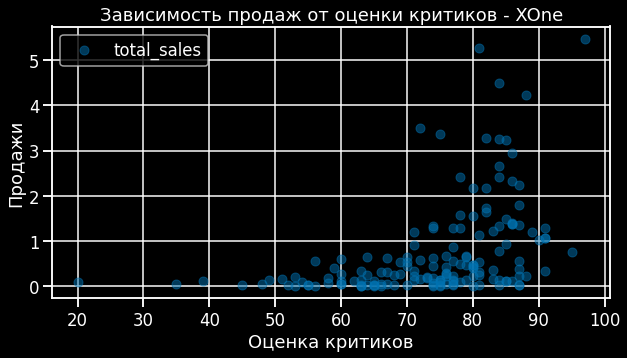

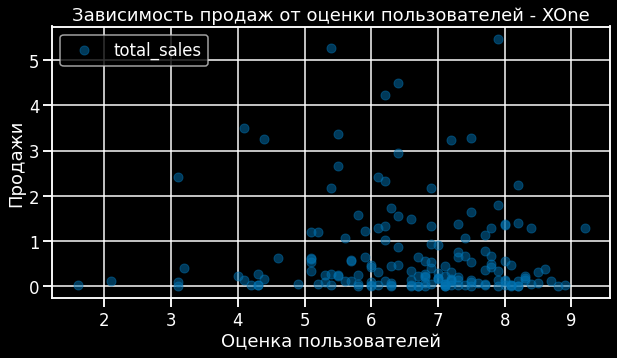

Коэффициент корреляции продажи/оценка пользователей: -0.07
Коэффициент корреляции продажи/оценка критиков: 0.37


In [40]:
# Построим диаграммы рассеяния для платформы XOne, исключим значения -1
xone_plat = df_plat.query('platform == "XOne" and critic_score != -1')
xone_plat.plot(
 x='critic_score',
 y='total_sales',
 style='o',
 grid=True,
 figsize=(10, 5),
 alpha=0.5,
)
plt.title('Зависимость продаж от оценки критиков - XOne')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи')
plt.show()

xone_plat = df_plat.query('platform == "XOne" and user_score != -1')
xone_plat.plot(
 x='user_score',
 y='total_sales',
 style='o',
 grid=True,
 figsize=(10, 5),
 alpha=0.5,
)
plt.title('Зависимость продаж от оценки пользователей - XOne')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи')
plt.show()

print('Коэффициент корреляции продажи/оценка пользователей:',\
      "{0:.2}".format(xone_plat['total_sales'].corr(xone_plat['user_score'])))
print('Коэффициент корреляции продажи/оценка критиков:', \
      "{0:.2}".format(xone_plat['total_sales'].corr(xone_plat['critic_score'])))

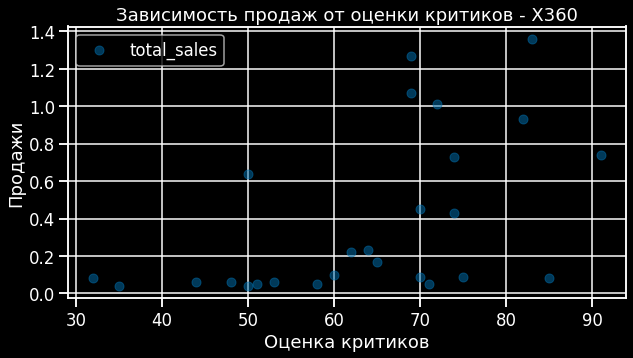

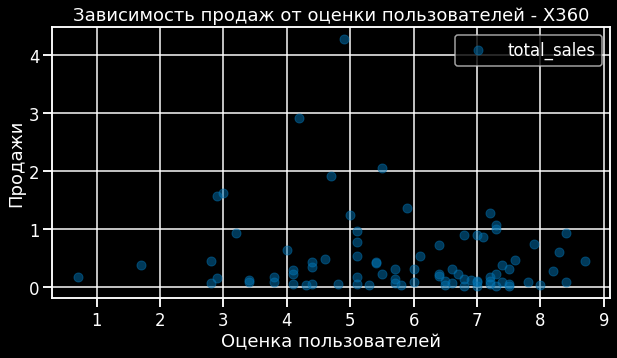

Коэффициент корреляции продажи/оценка пользователей: -0.14
Коэффициент корреляции продажи/оценка критиков: -0.051


In [41]:
# Построим диаграммы рассеяния для платформы X360, исключим значения -1
x360_plat = df_plat.query('platform == "X360" and critic_score != -1')
x360_plat.plot(
 x='critic_score',
 y='total_sales',
 style='o',
 grid=True,
 figsize=(10, 5),
 alpha=0.5,
)
plt.title('Зависимость продаж от оценки критиков - X360')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи')
plt.show()

x360_plat = df_plat.query('platform == "X360" and user_score != -1')
x360_plat.plot(
 x='user_score',
 y='total_sales',
 style='o',
 grid=True,
 figsize=(10, 5),
 alpha=0.5,
)
plt.title('Зависимость продаж от оценки пользователей - X360')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи')
plt.show()

print('Коэффициент корреляции продажи/оценка пользователей:', \
      "{0:.2}".format(x360_plat['total_sales'].corr(x360_plat['user_score'])))
print('Коэффициент корреляции продажи/оценка критиков:',\
      "{0:.2}".format(x360_plat['total_sales'].corr(x360_plat['critic_score'])))

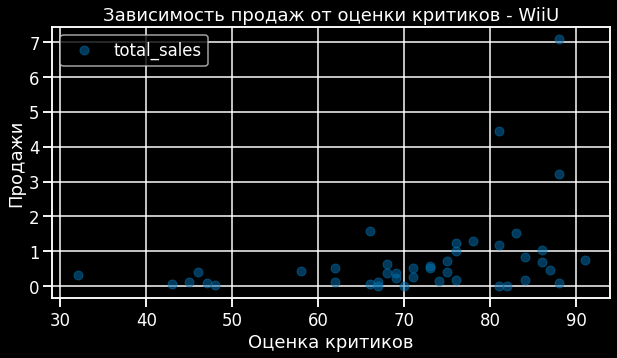

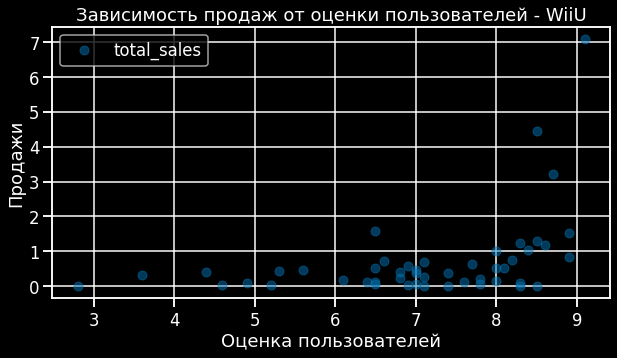

Коэффициент корреляции продажи/оценка пользователей: 0.41
Коэффициент корреляции продажи/оценка критиков: 0.34


In [42]:
# Построим диаграммы рассеяния для платформы WiiU, исключим значения -1
wiiu_plat = df_plat.query('platform == "WiiU" and critic_score != -1')
wiiu_plat.plot(
 x='critic_score',
 y='total_sales',
 style='o',
 grid=True,
 figsize=(10, 5),
 alpha=0.5,
)
plt.title('Зависимость продаж от оценки критиков - WiiU')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи')
plt.show()

wiiu_plat = df_plat.query('platform == "WiiU" and user_score != -1')
wiiu_plat.plot(
 x='user_score',
 y='total_sales',
 style='o',
 grid=True,
 figsize=(10, 5),
 alpha=0.5,
)
plt.title('Зависимость продаж от оценки пользователей - WiiU')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи')
plt.show()

print('Коэффициент корреляции продажи/оценка пользователей:', \
      "{0:.2}".format(wiiu_plat['total_sales'].corr(wiiu_plat['user_score'])))
print('Коэффициент корреляции продажи/оценка критиков:',\
      "{0:.2}".format(wiiu_plat['total_sales'].corr(wiiu_plat['critic_score'])))

#### Выводы
Корреляция по платформе PS4:
- Коэффициент корреляции продажи/оценка пользователей: -0.04 - отрицательная
- Коэффициент корреляции продажи/оценка критиков: 0.34 - слабая

Корреляция по платформе XOne:
- Коэффициент корреляции продажи/оценка пользователей: -0.07 - отрицательная
- Коэффициент корреляции продажи/оценка критиков: 0.37 - слабая

Корреляция по платформе X360:
- Коэффициент корреляции продажи/оценка пользователей: -0,14 - отрицательная
- Коэффициент корреляции продажи/оценка критиков: -0,051 - отрицательная

Корреляция по платформе WiiU:
Коэффициент корреляции продажи/оценка пользователей: 0.41 - слабая
Коэффициент корреляции продажи/оценка критиков: 0.34 - слабая

В целом, зависимости между отзывами пользователей/критиков и продажами не наблюдается.


#### Общее распределение игр по жанрам.
Построим график распределения игр по жанрам на основе сформированного ранее top_games и оценим жанры игр с наиболее высокими суммарными продажами.

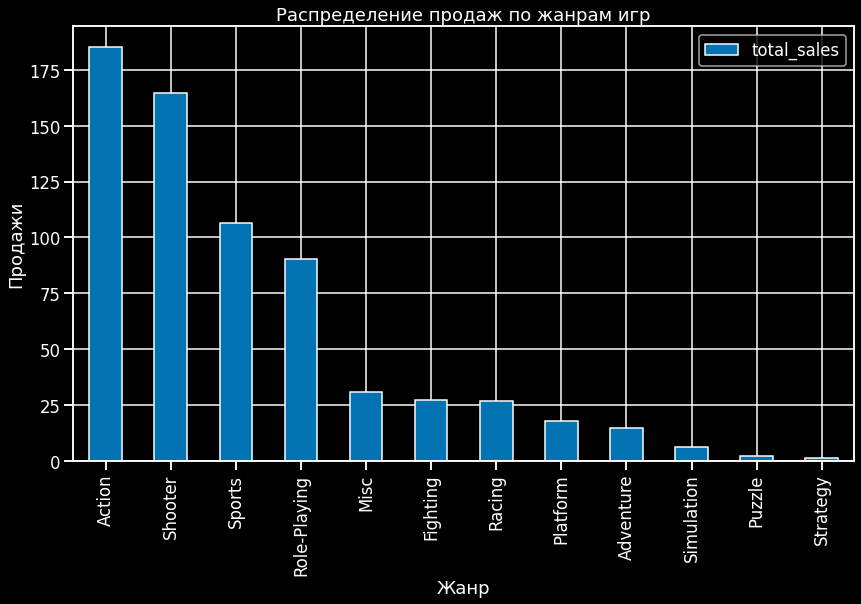

In [43]:
# Построим график распределения продаж по жанрам игр
(df_plat.pivot_table(index = 'genre', values = 'total_sales', aggfunc= 'sum')
.sort_values(by='total_sales', ascending=False)
.plot(y='total_sales', kind='bar', figsize=(14, 8), grid=True))
plt.title('Распределение продаж по жанрам игр')
plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.show()

#### Вывод
Самые прибыльные жанры:
- shooter
- action
- sports

Наименее популярные:
- platform
- adventure
- puzzle

### Шаг 4.
Составьте портрет пользователя каждого региона.
- Определите самые популярные платформы (топ-5). Опишите различия в долях продаж;
- Самые популярные жанры (топ-5). Поясните разницу;
- Влияет ли рейтинг ESRB?

#### Самые популярные платформы.

In [44]:
#определим суммарные продажи по платформам
na_reg = df_plat.groupby(['platform'])['na_sales'].agg(['sum']) #nord america
eu_reg = df_plat.groupby(['platform'])['eu_sales'].agg(['sum']) #europe
jp_reg = df_plat.groupby(['platform'])['jp_sales'].agg(['sum']) #japan

In [45]:
#объединим данные в одну таблицу
regions = pd.concat([na_reg, eu_reg,jp_reg], axis= 1 ).reset_index()

In [46]:
#check
regions.head(10)

,platform,sum,sum,sum
0,3DS,22.64,16.12,44.24
1,PS3,22.05,25.54,11.22
2,PS4,98.61,130.04,15.02
3,WiiU,19.36,13.15,7.31
4,X360,28.30,15.49,0.08
5,XOne,81.27,46.25,0.32


In [47]:
#rename columns
regions.columns = ['platform','america', 'europe', 'japan']

In [48]:
#check
regions.head()

,platform,america,europe,japan
0,3DS,22.64,16.12,44.24
1,PS3,22.05,25.54,11.22
2,PS4,98.61,130.04,15.02
3,WiiU,19.36,13.15,7.31
4,X360,28.30,15.49,0.08


In [ ]:
regions.

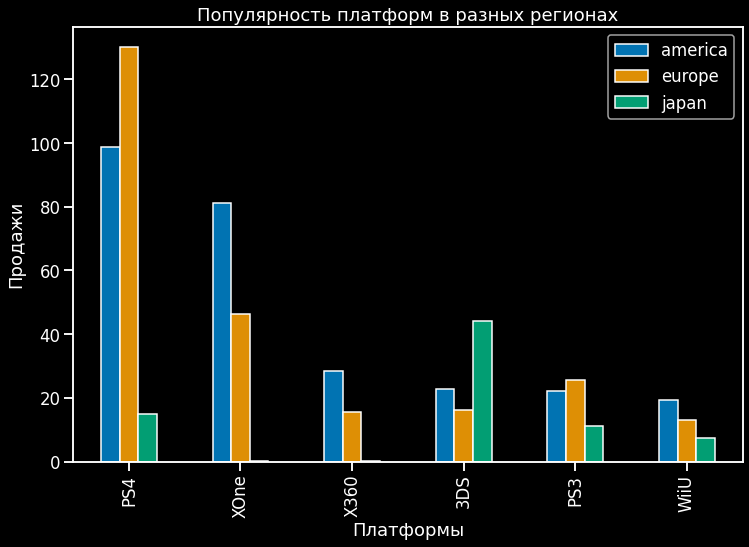

In [64]:
#построим график продаж в соотношении платформа/регион
regions.sort_values(by='america',ascending=False).plot.bar(x="platform", figsize =(12, 8))
plt.title('Популярность платформ в разных регионах')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

### Для Северной Америки ТОП-5:
1. PS4; 2. XOne; 3.X360; 4. 3DS; 5.PS3.


Для Европы:
1. PS4; 2. XOne; 3. PS3; 4. PC; 5. 3DS.


Рынок Японии наиболее специфичен, и ТОП-5 таков:
1. 3DS; 2. PS4; 3. PS3; 4.WiiU, 5.XOne.

In [50]:
#перевернем таблицу, чтобы построить график
regions_unpivot = pd.melt(regions, id_vars='platform', value_vars=['america', 'europe', 'japan'])

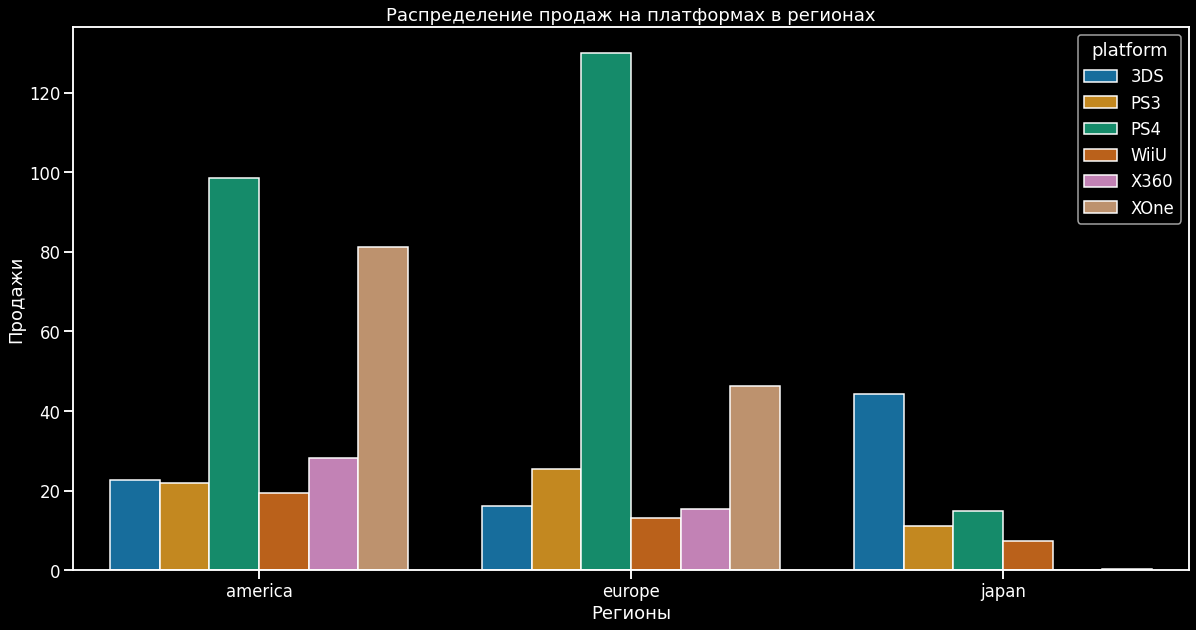

In [62]:
#строим график Распределение продаж на платформах в регионах
fig = plt.figure(figsize = (20,10))
sns.set_palette("colorblind")
af = sns.barplot(x='variable',
            y='value',
            hue="platform",
            data=regions_unpivot,
            palette="colorblind",
)

af.set_title('Распределение продаж на платформах в регионах')
af.set(xlabel='Регионы', ylabel='Продажи');

В целом, можно отметить, что наибольшая часть продаж приходится на Европу и Северную Америку. Рынок Японии значительно меньше.

#### Самые популярные жанры.

In [52]:
#определим суммарные продажи по жанрам
na_genre = df_actually.groupby(['genre'])['na_sales'].agg(['sum']) #nord america
eu_genre = df_actually.groupby(['genre'])['eu_sales'].agg(['sum']) #europe
jp_genre = df_actually.groupby(['genre'])['jp_sales'].agg(['sum']) #japan
#объединим данные в одну таблицу
genres = pd.concat([na_genre, eu_genre,jp_genre], axis= 1 ).reset_index()
#rename columns
genres.columns = ['genre','america', 'europe', 'japan']

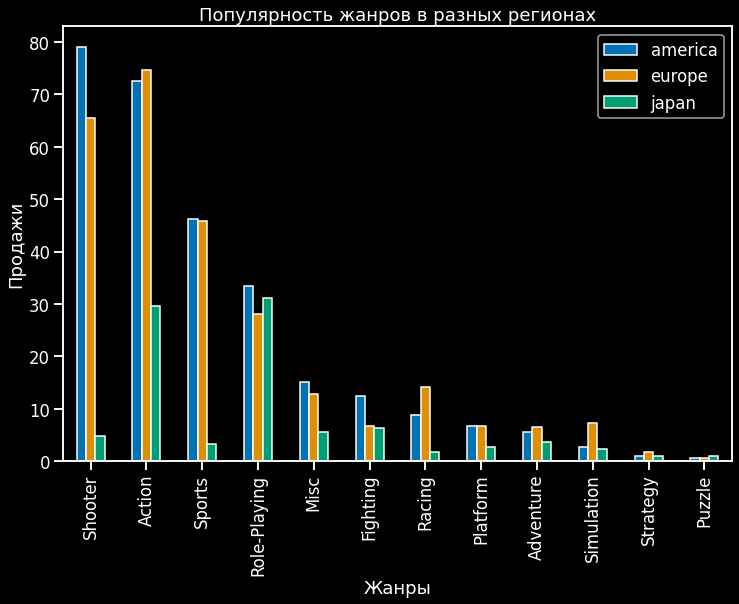

In [53]:
#построим график продаж в соотношении жанр/регион
genres.sort_values(by='america',ascending=False).plot.bar(x="genre", figsize =(12, 8))
plt.title('Популярность жанров в разных регионах')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()

В Северной Америке наиболее популярны: 1. shooter; 2. action; 3. sports; 4. role-playing; 5. misc.

В Европе: 1. action; 2. shooter; 3. sports; 4. role-playing; 5.racing. 

В Японии: 1. role-playing; 2. action; 3. fighting; 4. misc, 5. shooter.


Можно предположить, что разница в выборе жанра зависит от общего менталитета нации.

#### Влияет ли рейтинг ESRB?

In [54]:
#определим суммарные продажи по жанрам
na_rating = df_actually.groupby(['rating'])['na_sales'].agg(['sum']) #nord america
eu_rating = df_actually.groupby(['rating'])['eu_sales'].agg(['sum']) #europe
jp_rating = df_actually.groupby(['rating'])['jp_sales'].agg(['sum']) #japan
#объединим данные в одну таблицу
ratings = pd.concat([na_rating, eu_rating,jp_rating], axis= 1 ).reset_index()
#rename columns
ratings.columns = ['rating','america', 'europe', 'japan']

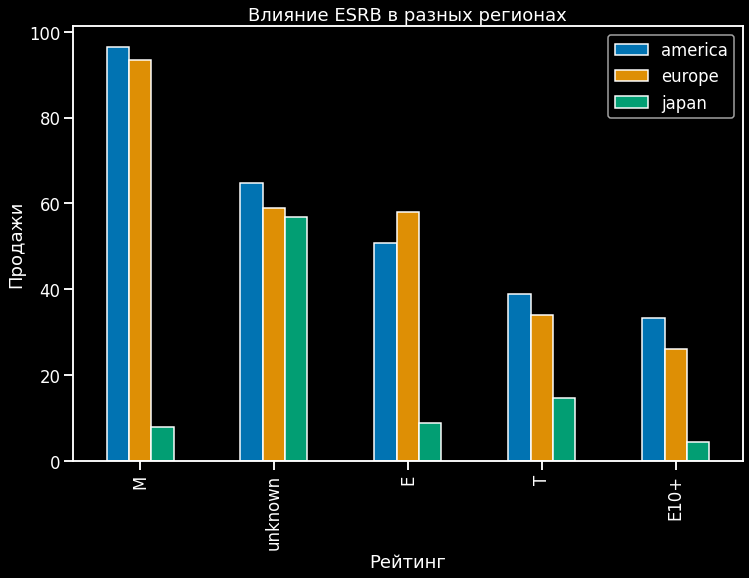

In [55]:
#построим график продаж в соотношении рейтинг/регион
ratings.sort_values(by='america',ascending=False).plot.bar(x="rating", figsize =(12, 8))
plt.title('Влияние ESRB в разных регионах')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи')
plt.show()

В Европе и Северной Америке большая часть проданных игр относится к рейтингу М (для взрослых), далее следует категория без рейтинга, после категория Е (для всех).

В Японии ситуация отличительно другая: большая часть проданных игр без определенной категории рейтинга, потом идет категория игр для тинейджеров и совсем малая часть приходится на категории М, Е, Е10+.

Предполагаю, что это связано с тем, что организация ESRB создана и действует на территории США и Канады. Оказывает значительное влияние на рынок Европы, т.к. экономики и развитие данных стран сильно интегрировано, в отличии от Японии.

### Шаг 5. Проверьте гипотезы.
- Средние пользовательские рейтинги платформ XOne и PC одинаковые.
- Средние пользовательские рейтинги жанров Action / Sports разные.

За нулевую гипотезу во втором случае примем : Средние пользовательские рейтинги жанров Action и Sports одинаковые, т.к. нам необходимо сформулировать нулевую гипотезу по принципу отсутствия различий.

H0: Средние пользовательские рейтинги платформ XOne и PC одинаковые.

H1: Средние пользовательские рейтинги платформ XOne и PC различаются.

In [56]:
df_actually[df_actually['user_score'] != -1]

results = st.ttest_ind(df_actually.query('platform == "XOne"')['user_score'],\
                       df_actually.query('platform == "PC"')['user_score'])

alpha = 0.05
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.2718222107871509
Не получилось отвергнуть нулевую гипотезу


Значение p-value больше 0.05, что означает, что отвергнуть нулевую гипотезу нельзя.

Средние пользовательские рейтинги жанров Action и Sports разные.

H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

Н1: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [57]:
df_actually[df_actually['user_score'] != -1]

results = st.ttest_ind(df_actually.query('genre == "Action"')['user_score'],\
                       df_actually.query('genre == "Sports"')['user_score'])

alpha = 0.05
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00046659782032851705
Отвергаем нулевую гипотезу


За нулевую гипотезу было принято "Средние пользовательские рейтинги жанров Action и Sports одинаковые" - именно эта гипотеза отвергнута. Соответственно, средние пользовательские рейтинги жанров Action и Sports разные.

### Общий вывод.
Было проведено исследование с целью выявления закономерностей определяющих успешность игры.
Задача: спрогнозировать кампанию на 2017 год.
Входные данные - исторические данные из открытых источников о продажах игр в регонах Северная Америка, Европа, Япония.

#### Общие выводы:
 - Активный рост рынка компьютерных игр начался с 2000 года, и продолжился до 2009 года, затем последовал спад, который продолжается вплоть до 2016 года;
 - Платформы, имеющие максимальные суммарные продажи PS2, X360, PS3, Wii, DS, PS;
 - В среднем "период актуальности" каждой платформы от 4 до 6 лет.
 

#### Актуальные выводы (2014-2016 года):
 - Платформы, имеющие максимальные суммарные продажи PS3, X360, PS4, 3DS, XOne,WiiU. Среди них можно выделить: PS4 и XOne.
 - Оценки критиков/пользователей на данных платформах не имеют сильного влияния на продажи игр;
 - Самые популярные жанры: shooter, action, sports. Наименее популярные: platform, adventure, puzzle;
 - Основная часть продаж производится на территории Северной Америки и Европы, доля Японии значительно меньше;
 - Рынок Северной Америки и Европы в целом достаточно похожи, рынок Японии отличается.

#### Составлен портрет пользователя для каждого региона (Северная Америка, Европа, Япония).
##### Северная Америка:
Платформа: 1. PS4; 2. XOne; 3.X360; 4. 3DS; 5.PS3;

Жанр: 1. shooter; 2. action; 3. sports; 4. role-playing; 5. misc;

Рейтинг ESRB: M, unknown, E, T, E10+.
##### Европa:
Платформа: 1.PS4; 2. XOne; 3. PS3; 4. PC; 5. 3DS.

Жанр: 1. action; 2. shooter; 3. sports; 4. role-playing; 5.racing.

Рейтинг ESRB: M, unknown, E, T, E10+.

##### Япония:
Платформа: 3DS; 2. PS4; 3. PS3; 4.WiiU, 5.XOne.

Жанр: 1. role-playing; 2. action; 3. fighting; 4. misc, 5. shooter.

Рейтинг ESRB: unknown, T, М, Е, Е10+ (практически не применимо).

### Проверка гипотез.
- Средние пользовательские рейтинги платформ XOne и PC одинаковые. - Гипотеза подтверждена.
- Средние пользовательские рейтинги жанров Action / Sports разные. - Гипотеза подтверждена.